In [253]:
%matplotlib inline
import math, time, random, datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

!pip install catboost
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection,tree,preprocessing,metrics,linear_model
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [254]:
train=pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
gender_submission=pd.read_csv('/content/gender_submission.csv')

In [255]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [256]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


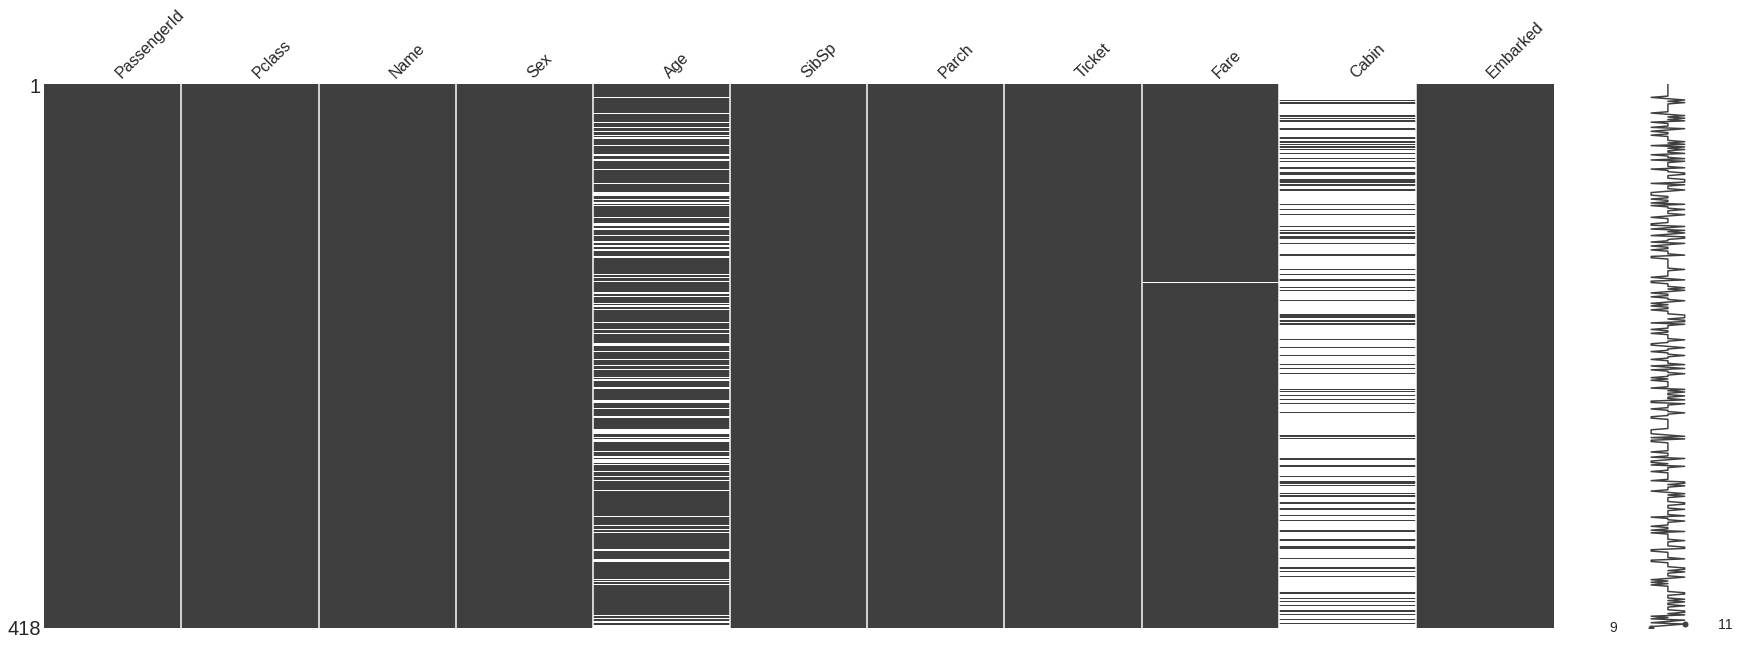

In [257]:
missingno.matrix(test,figsize=(30,10))

In [258]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [259]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

0    549
1    342
Name: Survived, dtype: int64


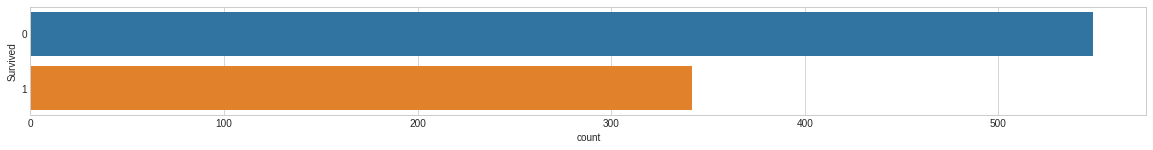

In [260]:
fig=plt.figure(figsize=(20,2))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [261]:
df_bin=pd.DataFrame()
df_con=pd.DataFrame()

In [262]:
df_bin['Survived']=train["Survived"]
df_con["Survived"]=train["Survived"]

In [263]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


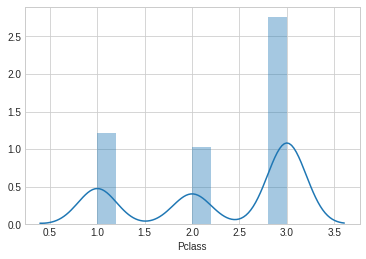

In [264]:
sns.distplot(train.Pclass)

In [265]:
train.Pclass.isnull().sum()

0

In [266]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [267]:
df_con

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3
...,...,...
886,0,2
887,1,1
888,0,3
889,1,1


In [268]:
train.Name.value_counts()

Canavan, Miss. Mary                                       1
Alhomaki, Mr. Ilmari Rudolf                               1
Rice, Master. Eric                                        1
Silverthorne, Mr. Spencer Victor                          1
Keane, Miss. Nora A                                       1
                                                         ..
Mellinger, Mrs. (Elizabeth Anne Maidment)                 1
Brown, Mr. Thomas William Solomon                         1
Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria Brogren)    1
Jacobsohn, Mr. Sidney Samuel                              1
Barbara, Mrs. (Catherine David)                           1
Name: Name, Length: 891, dtype: int64

male      577
female    314
Name: Sex, dtype: int64


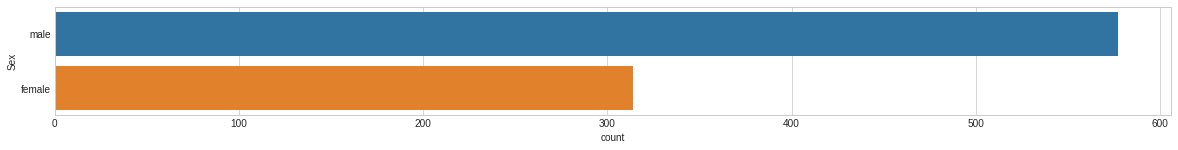

In [269]:
fig=plt.figure(figsize=(20,2))
sns.countplot(y='Sex',data=train)
print(train.Sex.value_counts())

In [270]:
df_bin['Sex']=train['Sex']
df_bin['Sex']=np.where(df_bin['Sex']=='female',1,0)
df_con['Sex']=train['Sex']

In [271]:
df_bin.Sex

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: int64

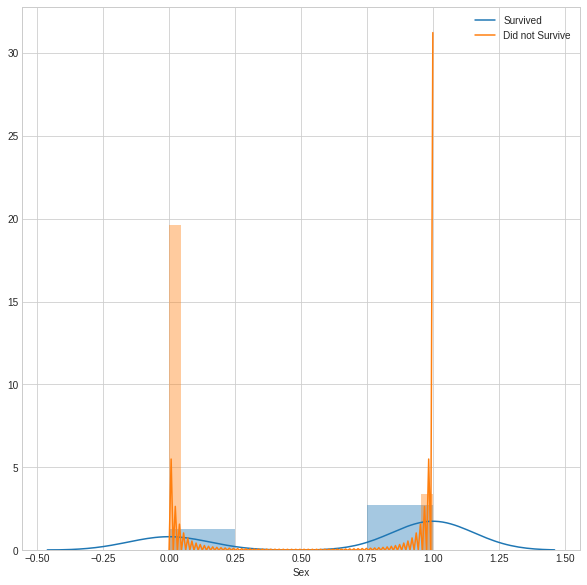

In [272]:
fig=plt.figure(figsize=(10,10))
sns.distplot(df_bin.loc[df_bin['Survived']==1]['Sex'],kde_kws={'label':'Survived'})
sns.distplot(df_bin.loc[df_bin['Survived']==0]['Sex'],kde_kws={'label':'Did not Survive'})

In [273]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

In [274]:
df_bin['SibSp']=train['SibSp']
df_con['SibSp']=train['SibSp']


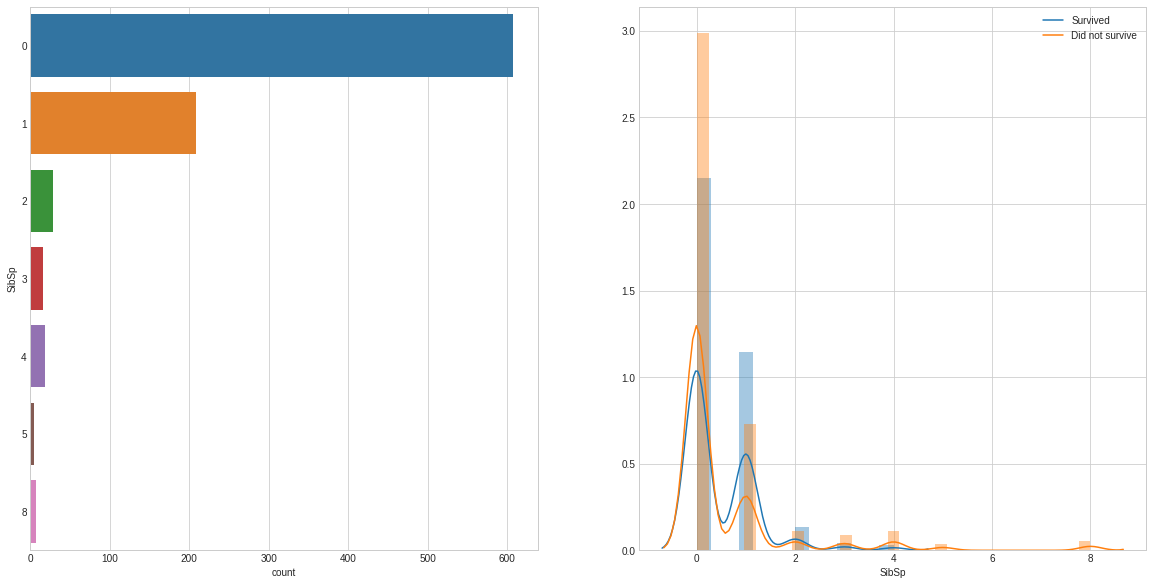

In [275]:
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

In [276]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [277]:
train.Parch.isnull().sum()

0

In [278]:
df_bin['Parch']=train['Parch']
df_con['Parch']=train['Parch']

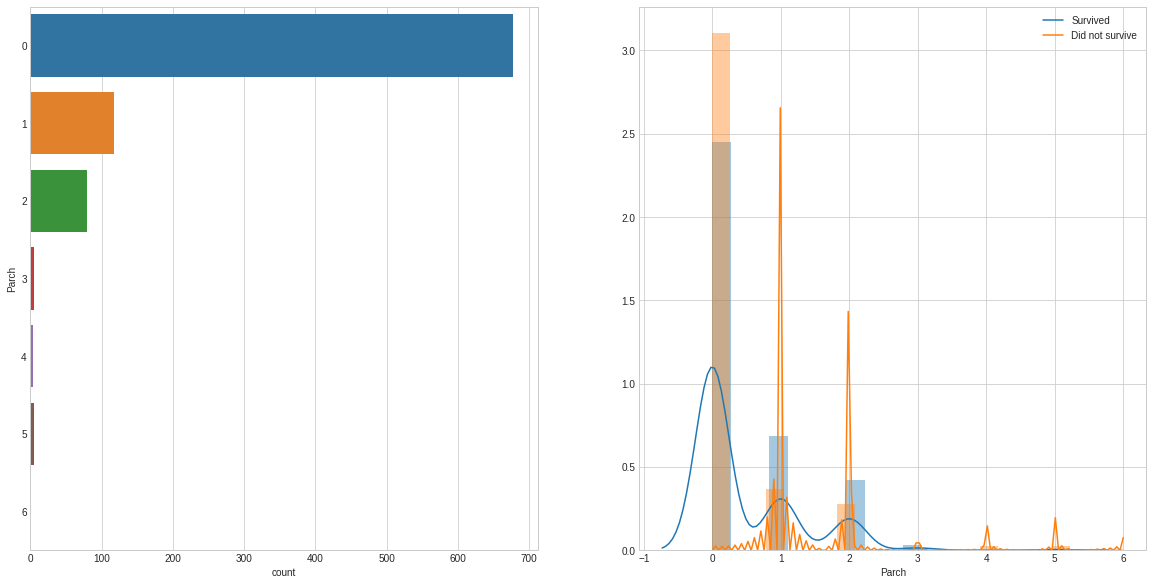

In [279]:
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

In [280]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [281]:
train.Ticket.isnull().sum()

0

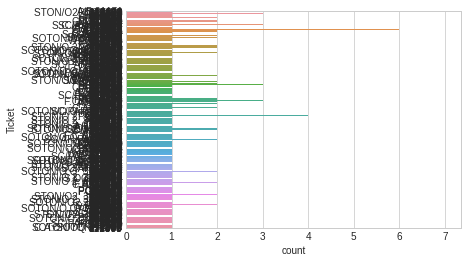

In [282]:
sns.countplot(y='Ticket',data=train)

In [283]:
train.Ticket.value_counts()

347082      7
1601        7
CA. 2343    7
3101295     6
347088      6
           ..
236171      1
330923      1
229236      1
367229      1
341826      1
Name: Ticket, Length: 681, dtype: int64

In [284]:
train.Fare.isnull().sum()

0

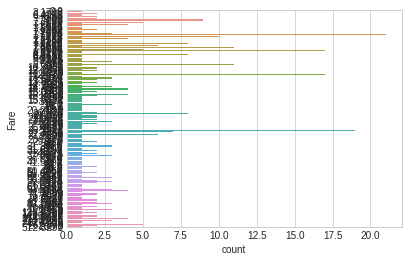

In [285]:
sns.countplot(y='Fare',data=test)

In [286]:
test.Fare.value_counts()

7.7500     21
26.0000    19
8.0500     17
13.0000    17
7.8958     11
           ..
9.3250      1
14.4583     1
15.0333     1
25.4667     1
21.0750     1
Name: Fare, Length: 169, dtype: int64

In [287]:
df_con['Fare']=train['Fare']
df_bin['Fare']=pd.cut(train['Fare'],bins=5)

In [288]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


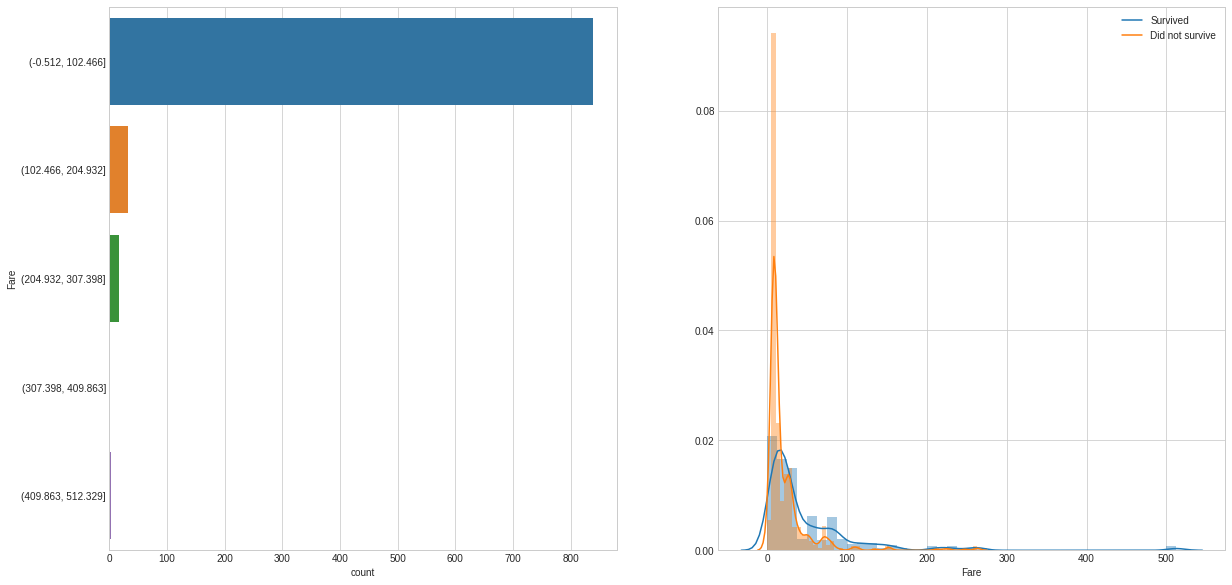

In [289]:
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

In [290]:
train.Cabin.isnull().sum()

687

In [291]:
train.Embarked.isnull().sum()

2

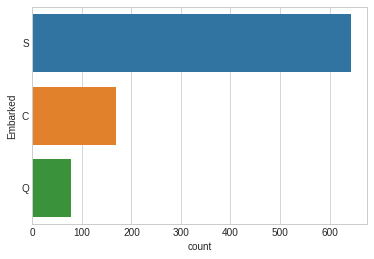

In [292]:
sns.countplot(y='Embarked',data=train)

In [293]:
df_bin['Embarked']=train['Embarked']
df_con['Embarked']=train['Embarked']

In [294]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [295]:
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])

In [296]:
df_bin

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S
...,...,...,...,...,...,...,...
886,0,2,0,0,0,"(-0.512, 102.466]",S
887,1,1,1,0,0,"(-0.512, 102.466]",S
888,0,3,1,1,2,"(-0.512, 102.466]",S
889,1,1,0,0,0,"(-0.512, 102.466]",C


In [297]:
df_bin.Embarked.isnull().sum()

0

In [298]:
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)
df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [299]:
df_bin_enc.shape

(889, 28)

In [300]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [301]:
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], prefix='embarked')
df_sex_one_hot = pd.get_dummies(df_con['Sex'], prefix='sex')
df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], prefix='pclass')

In [302]:
df_con_enc = pd.concat([df_con, df_embarked_one_hot, df_sex_one_hot, df_plcass_one_hot], axis=1)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [303]:
df_con_enc.head(10)

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,1,0,30.0708,1,0,0,1,0,0,1,0


In [304]:
selected_df=df_con_enc
selected_df.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [305]:
X_train=selected_df.drop('Survived',axis=1)
Y_train=selected_df.Survived

In [306]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [307]:
Y_train.head(10)

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

In [308]:
def fit_ml_algo(algo, X_train, Y_train, cv):

    model = algo.fit(X_train, Y_train)
    acc = round(model.score(X_train, Y_train) * 100, 2)
   
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  Y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(Y_train, train_pred) * 100, 2)
    return train_pred, acc, acc_cv

In [309]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                Y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:01.430833


In [310]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'], prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], prefix='pclass')

In [311]:
test = pd.concat([test, test_embarked_one_hot, test_sex_one_hot, test_plcass_one_hot], axis=1)

In [312]:
wanted_test_columns=X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [313]:
model = DecisionTreeClassifier().fit(X_train, Y_train)

In [314]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
test_predictors = imputer.fit_transform(test[wanted_test_columns])
predictions=model.predict(test_predictors)

In [315]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [316]:
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [317]:
submission.to_csv('/content/first_kaggle_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [318]:
submissions_check = pd.read_csv('/content/first_kaggle_submission.csv')
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
